## **Tutorial Overview: Comparing Active Learning Strategies with scikit-activeml**

This tutorial aims to demonstrate a practical comparison study using the ```scikit-activeml``` library [1]. The workflow involves utilizing a self-supervised learning model, specifically ```DINOv2``` from [2 - 4], to generate embeddings for the Flowers-102 datasets. Subsequently, various active learning strategies will be employed to intelligently select samples for labeling.

**Key Steps:**
1. **Self-Supervised Learning Model:** Utilize the DINOv2 model to create embedding datasets for CIFAR-10, CIFAR-100, and Flowers-102 datasets.

2. **Active Learning Strategies:** Employ different active learning strategies provided by the scikit-activeml library, including:
    - Random Sampling
    - Uncertainty Sampling
    - Discriminative Active Learning (DiscriminativeAL)
    - CoreSet
    - TypiClust
    - Badge

3. **Labeling Selection:** Use each active learning strategy to select specific samples for labeling, exploring diverse approaches to guide the learning process.

4. **Plotting the results:** By the end of this notebook, we'll have a comparision on the accuray of the aforementioned active learning strategies.

**References:**

[1] https://scikit-activeml.github.io/scikit-activeml-docs/index.html

[2] M. Oquab et al., ‘DINOv2: Learning Robust Visual Features without Supervision’. arXiv, Apr. 14, 2023. Accessed: Jan. 13, 2024. [Online]. Available: http://arxiv.org/abs/2304.07193

[3] https://dinov2.metademolab.com

[4] https://github.com/facebookresearch/dinov2

**Import Packages**

First, let's import the package we will beed for this project.

In [1]:
#!pip install -U matplotlib
#!pip install -U scikit-learn
#!pip install iteration_utiliti
#!pip3 install torch torchvision torchaudio
#!pip install tqdm

In [2]:
import sys
sys.path.append("/mnt/stud/home/jcheng/scikit-activeml/")

In [3]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling, RandomSampling, DiscriminativeAL, CoreSet, TypiClust, Badge
from skactiveml.utils import call_func, MISSING_LABEL

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm

import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

## Prepair your Data with DINOv2

In this step, we focus on preparing the datasets using the powerful self-supervised learning model DINOv2. DINOv2, short for "self-distillation with no labels", is a state-of-the-art model that excels at learning meaningful representations from unlabelled data.

If you've already completed these steps, you can skip ahead to loading your data. 

**Step 1: Transformation**

Apply necessary transformations to the datasets, including resizing images to a standardised format. This ensures consistency of input dimensions to the DINOv2 model.

In [4]:
transforms = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
    )

batch_size = 4

**Step 2: Load pretrained Model**
To calculate embeddings, we'll use DINOv2. Below we load the second smallest DINOv2 model to generate embedding datasets for the Flowers-102 datasets. 

In [5]:
dinov2_vitb14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vitb14")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dinov2_vitb14.to(device)

Using cache found in /mnt/stud/home/jcheng/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

**Step 3: Load Datasets and Generate Embeddings**

Firstly, we begin by loading the CIFAR-10, CIFAR-100, and Flowers-102 datasets.

After that, we employ the pre-trained DINOv2 model to generate embeddings for each image in the datasets and save them in a npy file.

In [13]:
def load_and_process_dataset(dataset_name, root_dir, is_train):
    # Load the dataset
    if is_train:
        split = 'train'
    else:
        split = 'val'
    
    dataset = datasets.__dict__[dataset_name](root=root_dir, split=split, download=True, transform=transforms)
        

    # Create a DataLoader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=2)

    embedding_list = []
    label_list = []

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=len(dataloader), desc=f"{dataset_name.capitalize()} {split}"):
            image, label = data
            embeddings = dinov2_vitb14(image.to(device)).cpu()
            embedding_list.append(embeddings)
            label_list.append(label)

        # Concatenate embeddings and labels
        X = torch.cat(embedding_list, dim=0).numpy()
        y_true = torch.cat(label_list, dim=0).numpy()

    return X, y_true

Applying on Flowers102 Datasets

In [16]:
# Flowers-102
flowers102_X_train, flowers102_y_train_true = load_and_process_dataset("Flowers102", "./data", True)
flowers102_X_test, flowers102_y_test_true = load_and_process_dataset("Flowers102", "./data", False)

np.save('./embedding_data/flowers102_dinov2B_X_train.npy', flowers102_X_train)
np.save('./embedding_data/flowers102_dinov2B_y_train.npy', flowers102_y_train_true)
np.save('./embedding_data/flowers102_dinov2B_X_test.npy', flowers102_X_test)
np.save('./embedding_data/flowers102_dinov2B_y_test.npy', flowers102_y_test_true)

Flowers102 val: 100%|██████████| 255/255 [00:43<00:00,  5.83it/s]


## Load your preprocessed Dataset

If you have previously processed your data with DINOv2, please use the following code to load your data. And we also define the number of classes in the Flowers102 dataset.

In [18]:
# Flowers-102
X_train = np.load('./embedding_data/flowers102_dinov2B_X_train.npy')
y_train_true = np.load('./embedding_data/flowers102_dinov2B_y_train.npy')
X_test = np.load('./embedding_data/flowers102_dinov2B_X_test.npy')
y_test_true = np.load('./embedding_data/flowers102_dinov2B_y_test.npy')

dataset_classes = 102

## Random Seed Management

To ensure experiment reproducibility, it's important to set random states for all components that might use them. For simplicity, we set a single fixed random state and use helper functions to generate new seeds and random states. It's important to note that the ```master_random_state``` should only be used to create new random states or random seeds.

In [20]:
master_random_state = np.random.RandomState(0)

def gen_seed(random_state:np.random.RandomState):
    return random_state.randint(0, 2**31)

def gen_random_state(random_state:np.random.RandomState):
    return np.random.RandomState(gen_seed(random_state))

## Classification Models and Query Strategies

The embeddings we have computed can be used as an input in a classification model. For this guide, we will be using LogisticRegression from ```sklearn``` [5]. Moreover, we handle the creation of query strategies using factory functions to simplify the seperation.

[5] ‘sklearn.linear_model.LogisticRegression’, scikit-learn. Accessed: Jan. 24, 2024. [Online]. Available: https://scikit-learn/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [31]:
clf = SklearnClassifier(LogisticRegression(), classes=np.arange(dataset_classes), random_state=gen_seed(master_random_state))

def create_query_strategy(name, random_state):
    return query_strategy_factory_functions[name](random_state)

query_strategy_factory_functions = {
    'RandomSampling': lambda random_state: RandomSampling(random_state=gen_seed(random_state)),
    'UncertaintySampling': lambda random_state: UncertaintySampling(random_state=gen_seed(random_state)),
    'DiscriminativeAL': lambda random_state: DiscriminativeAL(random_state=gen_seed(random_state)),
    'CoreSet': lambda random_state: CoreSet(random_state=gen_seed(random_state)),
    'TypiClust': lambda random_state: TypiClust(random_state=gen_seed(random_state)),
    'Badge': lambda random_state: Badge(random_state=gen_seed(random_state))
}

## Experiment Parameters

For this experiment, we need to define how the strategies should be compared against one another. Here the number of repetitions (```n_reps```), the numer of queries (```n_cycles```), the size of each query (```query_batch_size```) need to be difined. 

In [34]:
n_reps = 1
n_cycles = 25
query_batch_size = 16
query_strategy_names = query_strategy_factory_functions.keys()

## Experiment Loop

The actual experiment loops all over the query strategies. The average accuracy over the test set is recorded for each cycle and stored in the ```results``` dictionary.

In [35]:
results = {}

for qs_name in query_strategy_names:
    accuracies = np.full((n_reps, n_cycles), np.nan)
    for i_rep in range(n_reps):
        y_train = np.full(shape=y_train_true.shape, fill_value=MISSING_LABEL)
    
        qs = create_query_strategy(qs_name, random_state=gen_random_state(master_random_state))
        clf.fit(X_train, y_train)
        
        for c in tqdm(range(n_cycles), desc=f'Repeat {i_rep + 1} with {qs_name}'):
            query_idx = call_func(qs.query, X=X_train, y=y_train, batch_size=query_batch_size, clf=clf, discriminator=clf)
            y_train[query_idx] = y_train_true[query_idx]
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test_true)
            accuracies[i_rep, c] = score
    
    results[qs_name] = accuracies

Repeat 1 with Badge: 100%|██████████| 25/25 [01:15<00:00,  3.00s/it]


## Resulting Plotting

We use learning curves to compare strategies. We visualise the average accuracy, averaged over all repetitions and folds, relative to the number of queries. In addition, the legend provides insight into the area under the learning curve, which indicates the average accuracy over all cycles.

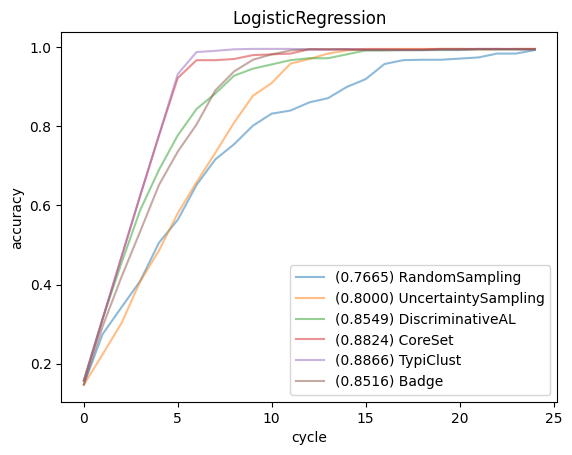

In [36]:
for qs_name in query_strategy_names:
    key = qs_name
    result = results[key]
    reshaped_result = result.reshape((-1, n_cycles))
    errorbar_mean = np.mean(reshaped_result, axis=0)
    plt.errorbar(np.arange(n_cycles), errorbar_mean, label=f"({np.mean(errorbar_mean):.4f}) {qs_name}", alpha=0.5)
plt.title("LogisticRegression")
plt.legend(loc='lower right')
plt.xlabel('cycle')
plt.ylabel('accuracy')
plt.show()